In [552]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import math
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [901]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv") 
#read data

In [903]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Clean data

In [554]:
#log transform the target:
y=list(train['SalePrice'])
y = np.log1p(y)
all_data = pd.concat((train,
                      test)).drop(['SalePrice','Id'],axis = 1)
#combine both data set to clean data

In [555]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str).astype(object)
#MSSubClass should be a categorical column

In [556]:
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [557]:
Dict = {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5,
             "Mn": 2, "Av": 3, 
             "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6,
             "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8,
             "RFn": 2, "Fin": 3,
             "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4,
             "N": 0, "Y": 1, np.nan:0
            }

for col in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
          'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond',
          'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'Fence', 
          'CentralAir']:

        all_data[col] = all_data[col].map(Dict).astype(int)

In [558]:
all_data = all_data.fillna({
    'Alley' : 'NoAlley',
    'MasVnrType': 'None',
    'FireplaceQu': 'NoFireplace',
    'GarageType': 'NoGarage',
    'GarageFinish': 'NoGarage',
    'GarageQual': 'NoGarage',
    'GarageCond': 'NoGarage',
    'BsmtFullBath': 0,
    'BsmtHalfBath': 0,
    'BsmtQual' : 'NoBsmt',
    'BsmtCond' : 'NoBsmt',
    'BsmtExposure' : 'NoBsmt',
    'BsmtFinType1' : 'NoBsmt',
    'BsmtFinType2' : 'NoBsmt',
    'KitchenQual' : 'TA',
    'MSZoning' : 'RL',
    'Utilities' : 'AllPub',
    'Exterior1st' : 'VinylSd',
    'Exterior2nd'   : 'VinylSd',
    'Functional' : 'Typ',
    'PoolQC' : 'NoPool',
    'Fence' : 'NoFence',
    'MiscFeature' : 'None',
    'Electrical' : 'SBrkr'
     
})


all_data.loc[all_data.SaleCondition.isnull(), 'SaleCondition'] = 'Normal'
all_data.loc[all_data.SaleCondition.isnull(), 'SaleType'] = 'WD'
all_data.loc[all_data.MasVnrType == 'None', 'MasVnrArea'] = 0

all_data.loc[all_data.BsmtFinSF1.isnull(), 'BsmtFinSF1'] = all_data.BsmtFinSF1.median()
all_data.loc[all_data.BsmtUnfSF.isnull(), 'BsmtUnfSF'] = all_data.BsmtUnfSF.median()






# only one is null and it has type Detchd
all_data.loc[all_data['GarageArea'].isnull(), 'GarageArea'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageArea'].mean()
all_data.loc[all_data['GarageCars'].isnull(), 'GarageCars'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageCars'].median()

In [559]:
#drop predictor according to Shu's code
all_data = all_data.drop(['Street','Utilities','Condition2','RoofMatl',
                         'LowQualFinSF','3SsnPorch','PoolArea','PoolQC','MiscVal','GarageYrBlt'],axis = 1)

In [560]:
#warnings.simplefilter('ignore', np.RankWarning)
# I have no idea how to do it better. Probably, it is better to do nothing
a1 = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotArea"]
a2 = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotFrontage"]
# plt.scatter(x, y)
t = (a1 <= 25000) & (a2 <= 150)
p = np.polyfit(a1[t], a2[t], 1)
all_data.loc[all_data['LotFrontage'].isnull(), 'LotFrontage'] = np.polyval(p, all_data.loc[all_data['LotFrontage'].isnull(), 'LotArea'])

In [887]:
all_data['BsmtFinSF2'].fillna(0,inplace = True)
all_data['TotalBsmtSF'].fillna(0,inplace = True)
# all_data.isnull().sum()  TotalBsmtSF

In [888]:
all_data.isnull().any()

1stFlrSF                 False
2ndFlrSF                 False
BedroomAbvGr             False
BsmtCond                 False
BsmtFinSF1               False
BsmtFinSF2               False
BsmtFinType1             False
BsmtFinType2             False
BsmtFullBath             False
BsmtHalfBath             False
BsmtQual                 False
BsmtUnfSF                False
CentralAir               False
EnclosedPorch            False
ExterCond                False
ExterQual                False
Fence                    False
FireplaceQu              False
Fireplaces               False
FullBath                 False
Functional               False
GarageArea               False
GarageCars               False
GarageCond               False
GarageFinish             False
GarageQual               False
GrLivArea                False
HalfBath                 False
HeatingQC                False
KitchenAbvGr             False
KitchenQual              False
LotArea                  False
LotFront

In [883]:
np.isfinite(all_data).any()

1stFlrSF                 True
2ndFlrSF                 True
BedroomAbvGr             True
BsmtCond                 True
BsmtFinSF1               True
BsmtFinSF2               True
BsmtFinType1             True
BsmtFinType2             True
BsmtFullBath             True
BsmtHalfBath             True
BsmtQual                 True
BsmtUnfSF                True
CentralAir               True
EnclosedPorch            True
ExterCond                True
ExterQual                True
Fence                    True
FireplaceQu              True
Fireplaces               True
FullBath                 True
Functional               True
GarageArea               True
GarageCars               True
GarageCond               True
GarageFinish             True
GarageQual               True
GrLivArea                True
HalfBath                 True
HeatingQC                True
KitchenAbvGr             True
KitchenQual              True
LotArea                  True
LotFrontage              True
MasVnrArea

In [564]:
all_data.columns

Index(['1stFlrSF', '2ndFlrSF', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond',
       'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF',
       'CentralAir', 'Condition1', 'Electrical', 'EnclosedPorch', 'ExterCond',
       'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu',
       'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageArea',
       'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType',
       'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle',
       'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotArea',
       'LotConfig', 'LotFrontage', 'LotShape', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MoSold', 'Neighborhood',
       'OpenPorchSF', 'OverallCond', 'OverallQual', 'PavedDrive', 'RoofStyle',
       'SaleCondition', 'SaleType', 'ScreenPorch', 'TotRmsAbvGrd',
       'TotalBsmtSF', 'W

###Data preprocessing: 
We're not going to do anything fancy here: 
 
- First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal    
- Create Dummy variables for the categorical features    
- Replace the numeric missing values (NaN's) with the mean of their respective columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A06023DC50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001A06028CAC8>]], dtype=object)

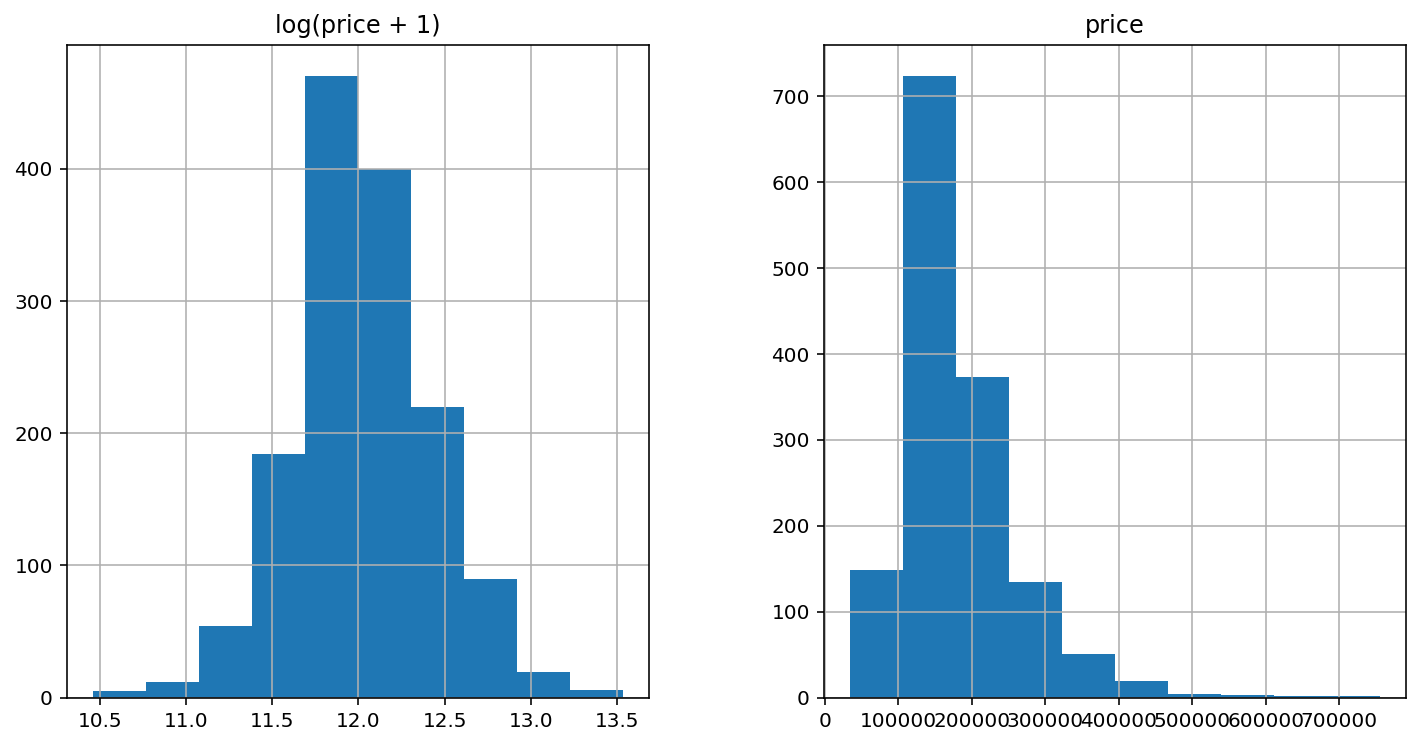

In [565]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [566]:
#filling NA's with the mean of the column:
all_data = all_data.replace(0,all_data.mean())
from numpy import inf
all_data = all_data.replace(-inf , 0)
all_data = all_data.replace(inf , 0)

In [889]:
all_data = pd.get_dummies(all_data)

In [890]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = np.log1p(train["SalePrice"])

In [569]:
# X_train.isnull().sum()
# np.isfinite(X_train).sum()

## ElasticNet

In [333]:
from sklearn.linear_model import ElasticNet
regr = ElasticNet(random_state=0)

In [909]:
from sklearn.model_selection import GridSearchCV
grid_el = {'alpha': [0.01],
           'l1_ratio':[0.02],
          'fit_intercept':[True],
          'normalize':[False]}

grid_search_E = GridSearchCV(estimator = regr, param_grid = grid_el, cv = 10, n_jobs = -1, 
                           verbose = 2, scoring = 'neg_mean_squared_error')

In [910]:
grid_search_E.fit(X_train, y)
grid_search_E.best_params_
# {'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 0.02, 'normalize': False}

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished


{'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 0.02, 'normalize': False}

In [911]:
from math import sqrt
sqrt(-grid_search_E.best_score_) #skew : 0.1325324059474199

0.12556617381222593

## Lasso

In [1013]:

model_lasso = LassoCV(alphas = [  0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()


0.12262581386102198

In [1011]:
lasso_preds = np.expm1(model_lasso.predict(X_test))

## Random Forest

In [986]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 0)
param_grid = {'n_estimators': [3000],
               'max_features': ['sqrt'],
               'max_depth': [21],
#                'min_samples_split': [2],
#                'min_samples_leaf': [1],
               'bootstrap' : [False]
               }

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                           cv = 10, n_jobs = -1, verbose = 2, scoring = 'neg_mean_squared_error')

In [987]:
grid_search.fit(X_train, y)
grid_search.best_params_

# {'bootstrap': False,
#  'max_depth': 21,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'n_estimators': 1000}

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


{'bootstrap': False,
 'max_depth': 21,
 'max_features': 'sqrt',
 'n_estimators': 3000}

In [988]:
sqrt(-grid_search.best_score_) #skew :0.1389821283984828

0.13621974413337026

## Graident Boosting

In [1016]:
#gbm
from sklearn.ensemble import GradientBoostingRegressor
params = {'max_features': ['sqrt'],
#           'min_samples_split': [10],#
#           'min_samples_leaf': [2],
          'max_depth': [4,5],
          'n_estimators':[1500],
          'learning_rate':[0.01,0.04],
          'subsample':[0.7,0.8],
          'loss':['huber'],
          }
gbm = GradientBoostingRegressor(random_state = 1)
grid_search = GridSearchCV(estimator = gbm, param_grid = params,
                           cv = 10, n_jobs = -1, verbose = 2, scoring = 'neg_mean_squared_error')

In [1017]:
grid_search.fit(X_train, y)
print(grid_search.best_params_)
sqrt(-grid_search.best_score_)
# {'learning_rate': 0.01, 'loss': 'huber', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 3000, 'subsample': 0.7}
# 0.11574630876794141

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.9min finished


{'learning_rate': 0.04, 'loss': 'huber', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 1500, 'subsample': 0.7}


0.11476506079711307

http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

## Xgboosting

In [696]:
score_xgb =[]

In [1024]:
import xgboost as xgb
param_xgb = {
#      'colsample_bytree':[0.31], #
             'gamma':[0.01], #
             'learning_rate':[0.07,0.06,0.08], #0.04
#              'max_depth':[3], #
#              'min_child_weight':[0.25],#
             'n_estimators':[1000],
             'reg_alpha':[0.04], #1
             'reg_lambda':[0.29,0.28],#
              'subsample':[0.595], #0.6
#               'silent':[1],
              'random_state':[7], #
#               'nthread':[-1],
              }#
xgb1 = xgb.XGBRegressor()
grid_xgb = GridSearchCV(estimator = xgb1, param_grid = param_xgb,cv = 3, n_jobs = -1, verbose = 2,scoring = 'neg_mean_squared_error')

In [1025]:
grid_xgb.fit(X_train, y)
print(grid_xgb.best_params_)
sqrt(-grid_xgb.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000001A02A3AD3C8>>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   49.0s finished


{'gamma': 0.01, 'learning_rate': 0.06, 'n_estimators': 1000, 'random_state': 7, 'reg_alpha': 0.04, 'reg_lambda': 0.29, 'subsample': 0.595}


0.12064878234326104

## SVR

In [835]:
import numpy as np
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

grid = {'C' : [1,2,3,5,10],
            'epsilon':[0.1]}
            #'intercept_scaling': 1.0, loss='epsilon_insensitive', max_iter=1000}
grid_SVR= GridSearchCV(SVR(kernel = 'linear'), param_grid =grid, cv =10, scoring = 'neg_mean_squared_error',n_jobs=-1,verbose=2,)
grid_SVR.fit(X_train,y)
print(sqrt(-grid_SVR.best_score_))

## Stacking

In [846]:
from stacking import stacking_regression
from sklearn.metrics import mean_squared_error

In [847]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [998]:
models = [ 
    # linear model, ElasticNet = lasso + ridge
#     ElasticNet(random_state=0,alpha=0.01,fit_intercept=True,l1_ratio=0.02,normalize=False), 
    #random forest
#     RandomForestRegressor(random_state = 0,n_estimators=3000,max_features='sqrt',max_depth=21,min_samples_split=2,
#                          min_samples_leaf=1,bootstrap=False),

    
    #Lasso
#     from sklearn import linear_model
#     linear_model.Lasso(alpha = 0.0005)
    
    # gbr model
    GradientBoostingRegressor(random_state=1, learning_rate = 0.01, max_features='sqrt',n_estimators=3000, max_depth=4,subsample=0.7,loss='ls'),
    
    # xgb

    xgb.XGBRegressor(random_state = 7, learning_rate = 0.0275 ,gamma=0.01,reg_alpha=0.04,reg_lambda=0.29,subsample=0.595,n_estimators =3000, max_depth = 3),]
from sklearn.linear_model import ElasticNet, LinearRegression as lr
meta_model = lr(normalize=True)

In [945]:
# stack with four

final_predictionall = stacking_regression(models, meta_model, X_train, y, X_test,metric=rmsle, 
                                       verbose=1,transform_pred = np.expm1)
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = final_predictionall
sub.to_csv('submission_all.csv',index=False)

metric: [rmsle]

model 0: [ElasticNet]
    ----
    MEAN:   [193777.83866234]

model 1: [RandomForestRegressor]
    ----
    MEAN:   [187903.25168354]

model 2: [GradientBoostingRegressor]
    ----
    MEAN:   [192931.44470570]

model 3: [XGBRegressor]
    ----
    MEAN:   [194172.16244812]



In [894]:
# stack with three
%%time
final_prediction = stacking_regression(models, meta_model, X_train, y, X_test,metric=rmsle, 
                                       verbose=1,transform_pred = np.expm1)
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = final_prediction
sub.to_csv('submission_3w.csv',index=False)

metric: [rmsle]

model 0: [ElasticNet]
    ----
    MEAN:   [0.12736421]

model 1: [GradientBoostingRegressor]
    ----
    MEAN:   [0.11778158]

model 2: [XGBRegressor]
    ----
    MEAN:   [0.11953592]

Wall time: 31.5 s


In [999]:
# stack with boosting
final_prediction1 = stacking_regression(models, meta_model, X_train, y, X_test,metric=rmsle, 
                                        verbose=1,transform_pred = np.expm1)
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = final_prediction1
sub.to_csv('submission_b.csv',index=False)

metric: [rmsle]

model 0: [GradientBoostingRegressor]
    ----
    MEAN:   [193000.51015524]

model 1: [XGBRegressor]
    ----
    MEAN:   [194360.54295107]



In [917]:
#random forest and elasticnet
final_prediction2 = stacking_regression(models, meta_model, X_train, y, X_test,metric=rmsle, verbose=1,
                                        transform_pred = np.expm1)
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = final_prediction2
sub.to_csv('submission_fel.csv',index=False)

metric: [rmsle]

model 0: [ElasticNet]
    ----
    MEAN:   [193777.83866234]

model 1: [RandomForestRegressor]
    ----
    MEAN:   [187903.25168354]



So for the Ridge regression we get a rmsle of about 0.127

Let' try out the Lasso model. We will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha for us. For some reason the alphas in Lasso CV are really the inverse or the alphas in Ridge.

In [952]:
model_lasso = LassoCV(alphas = [ 1,0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()
lasso_preds = np.expm1(model_lasso.predict(X_test))

0.12262581386102198

Nice! The lasso performs even better so we'll just use this one to predict on the test set. Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [954]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [955]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 100 variables and eliminated the other 125 variables


Good job Lasso.  One thing to note here however is that the features selected are not necessarily the "correct" ones - especially since there are a lot of collinear features in this dataset. One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.

We can also take a look directly at what the most important coefficients are:

In [956]:
imp_coef = pd.concat([coef.sort_values().head(20),
                     coef.sort_values().tail(20)])

Text(0.5,1,'Coefficients in the Lasso Model')

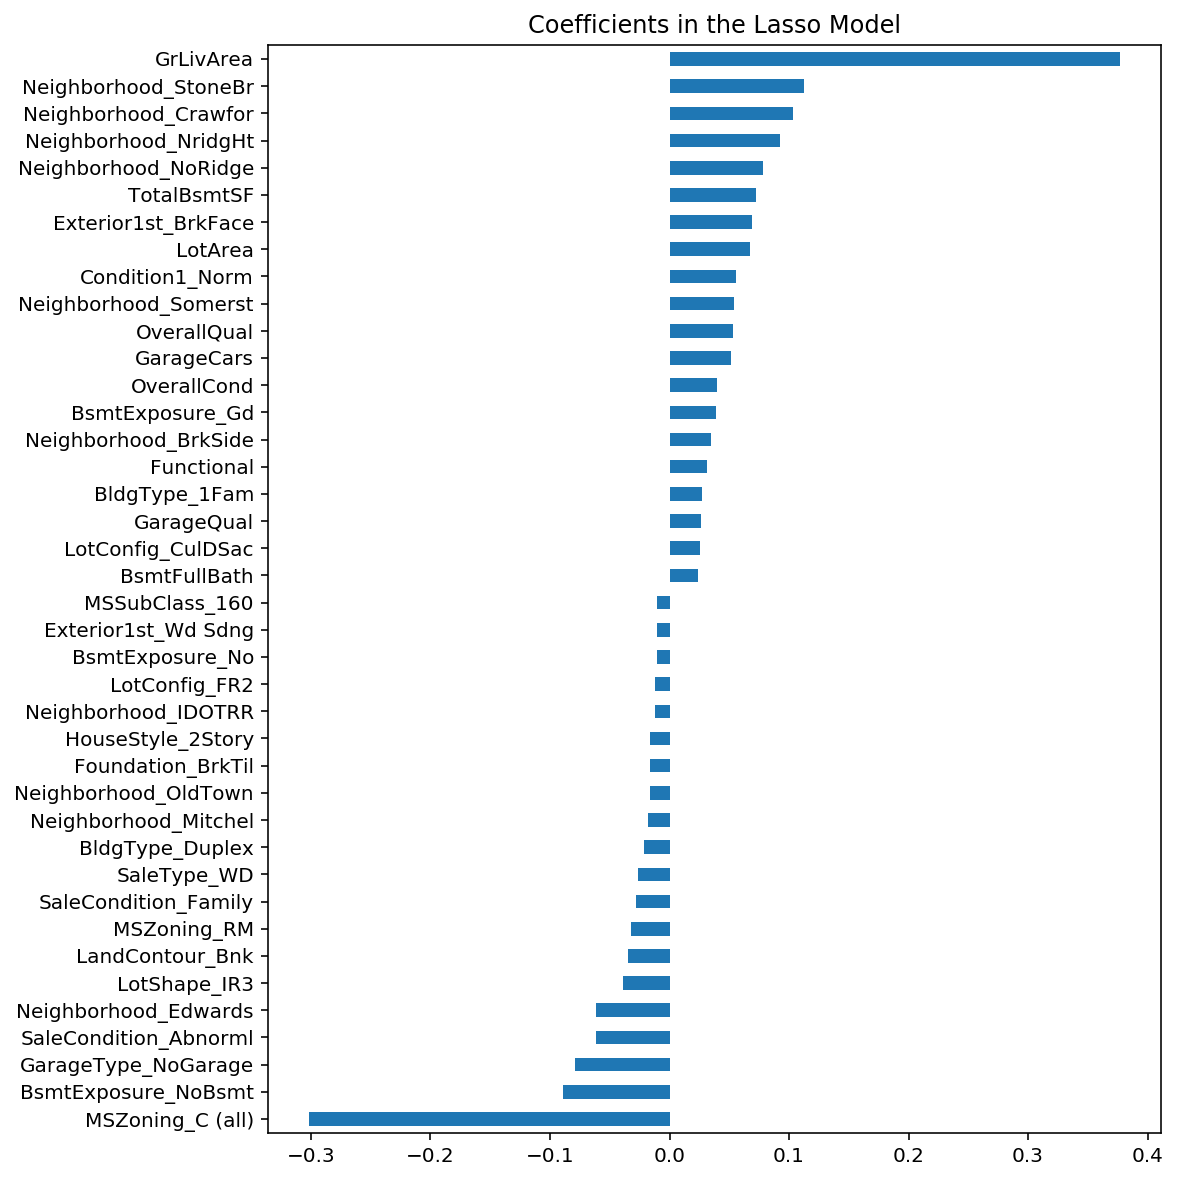

In [957]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

The most important positive feature is `GrLivArea` -  the above ground area by area square feet. This definitely sense. Then a few other  location and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

 Also note that unlike the feature importance you'd get from a random forest these are _actual_ coefficients in your model - so you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret. 

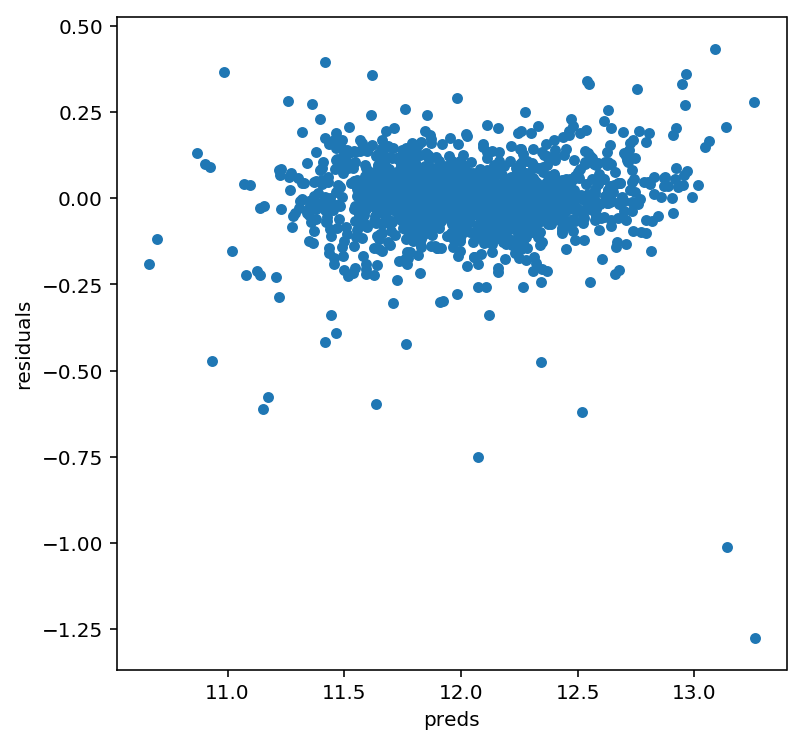

In [958]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

The residual plot looks pretty good.To wrap it up let's predict on the test set and submit on the leaderboard:

Let's add an xgboost model to our linear model to see if we can improve our score:

In [959]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)

In [1022]:

dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

In [1023]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(dtrain, y)
xgb_preds = np.expm1(model_xgb.predict(X_test))

TypeError: can not initialize DMatrix from DMatrix

In [ ]:

lasso_preds = np.expm1(model_lasso.predict(X_test))

In [962]:
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = lasso_preds
sub.to_csv('submission_lasso.csv',index=False)